# Model Analysis/Model building 

---

### Essential Libraries

Let us begin by importing the essential Python Libraries.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

In [7]:
# Core libraries and model APIs
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

sns.set_theme(style="whitegrid", palette="deep")
pd.options.display.float_format = '{:,.2f}'.format

---

## Setup : Import the Dataset

Dataset from Kaggle : The **"House Prices"** competition     
Source: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

The dataset is `train.csv`; hence we use the `read_csv` function from Pandas.  
Immediately after importing, take a quick look at the data using the `head` function.

In [2]:
from pathlib import Path
import pandas as pd

# Load and tidy the engineered feature sheet
ctg_path = Path("ctg_cleaned_output.csv")
assert ctg_path.exists(), f"Expected CSV file at {ctg_path.resolve()}"

def read_feature_sheet(path: Path):
    """Load the CTG feature sheet from a CSV file."""
    try:
        df = pd.read_csv(path)
    except Exception as e:
        raise ValueError(f"Error reading CSV file: {e}")
    return df

raw_features = read_feature_sheet(ctg_path)
raw_features.shape

(2128, 29)

In [4]:
# Load and tidy the engineered feature sheet
ctg_path = Path("ctg_cleaned_output.csv")
assert ctg_path.exists(), f"Expected CSV file at {ctg_path.resolve()}"

def read_feature_sheet(path: Path):
    """Load the CTG feature sheet from a CSV file."""
    try:
        df = pd.read_csv(path)
    except Exception as e:
        raise ValueError(f"Error reading CSV file: {e}")
    return df

raw_features = read_feature_sheet(ctg_path)
raw_features.shape


# Clean columns, drop leakage, and ensure numerics
def tidy_sheet(df: pd.DataFrame) -> pd.DataFrame:
    cleaned = df.copy()
    cleaned.columns = [str(col).strip() for col in cleaned.columns]
    cleaned = cleaned.dropna(axis=0, how='all').dropna(axis=1, how='all')
    cleaned = cleaned.loc[:, ~cleaned.columns.str.contains('^Unnamed', case=False)]
    cleaned = cleaned.loc[:, ~cleaned.columns.duplicated()]
    rename_map = {
        'MSTV': 'mSTV',
        'MLTV': 'mLTV',
        'Variance ': 'Variance',
        'TENDENCY': 'Tendency'
    }
    cleaned = cleaned.rename(columns={k: v for k, v in rename_map.items() if k in cleaned.columns})
    return cleaned

sheet2 = tidy_sheet(raw_features)
target_col = 'NSP'
label_leak_cols = ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']
feature_cols = [col for col in sheet2.columns if col not in label_leak_cols + [target_col]]
clean_df = (
    sheet2
    .drop(columns=label_leak_cols, errors='ignore')
    .dropna(axis=0, how='all')
    .drop_duplicates()
)

# Coerce numeric columns and drop rows without labels
numeric_cols = feature_cols
clean_df[numeric_cols] = clean_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
clean_df = clean_df.dropna(subset=[target_col]).copy()
clean_df[target_col] = clean_df[target_col].astype(int)

X = clean_df[numeric_cols]
y = clean_df[target_col]
X.shape, y.value_counts().sort_index()

((2126, 28),
 NSP
 1    1655
 2     295
 3     176
 Name: count, dtype: int64)

In [8]:
# Stratified train/test split and class weights
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Compute class weights
classes = np.unique(y_train)
class_weight_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weight_values))
sample_weight_train = compute_sample_weight(class_weight='balanced', y=y_train)

# Data distribution summary
distribution = (
    pd.DataFrame({
        'Split': ['Train', 'Test'],
        'Size': [len(y_train), len(y_test)],
        'Normal (1)': [np.mean(y_train == 1), np.mean(y_test == 1)],
        'Suspect (2)': [np.mean(y_train == 2), np.mean(y_test == 2)],
        'Pathologic (3)': [np.mean(y_train == 3), np.mean(y_test == 3)]
    })
    .rename(columns=lambda c: c if c in {'Split', 'Size'} else f'{c} proportion')
)

distribution, class_weight_dict

(   Split  Size  Normal (1) proportion  Suspect (2) proportion  \
 0  Train  1488                   0.78                    0.14   
 1   Test   638                   0.78                    0.14   
 
    Pathologic (3) proportion  
 0                       0.08  
 1                       0.08  ,
 {1: 0.4283246977547496, 2: 2.396135265700483, 3: 4.032520325203252})

In [9]:
# Shared evaluation helper
results = []

def evaluate_model(name, estimator, X_train, y_train, X_test, y_test, fit_kwargs=None, display_report=False):
    fit_kwargs = fit_kwargs or {}
    estimator.fit(X_train, y_train, **fit_kwargs)
    y_pred = estimator.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append({'Model': name, 'Balanced Accuracy': bal_acc, 'F1 Macro': f1})
    print(f"{name} — Balanced Accuracy: {bal_acc:.3f}, Macro F1: {f1:.3f}")
    if display_report:
        print(classification_report(y_test, y_pred, digits=3))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=sorted(classes), normalize='true', cmap='Blues'
    )
    disp.ax_.set_title(f"{name} — Normalized Confusion Matrix")
    plt.show()
    return estimator, y_pred

classes

array([1, 2, 3])

## Logistic Regression

Logistic Regression — Balanced Accuracy: 0.838, Macro F1: 0.784
              precision    recall  f1-score   support

           1      0.991     0.873     0.928       497
           2      0.527     0.886     0.661        88
           3      0.769     0.755     0.762        53

    accuracy                          0.865       638
   macro avg      0.762     0.838     0.784       638
weighted avg      0.908     0.865     0.878       638



/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['FileName' 'Date' 'SegFile']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['FileName' 'Date' 'SegFile']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


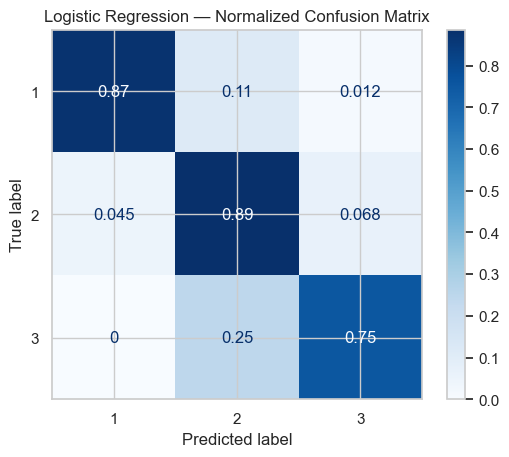

In [10]:
log_reg_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(
        max_iter=1000,
        multi_class='multinomial',
        class_weight='balanced',
        solver='lbfgs'
    ))
])
_ = evaluate_model('Logistic Regression', log_reg_pipeline, X_train, y_train, X_test, y_test, display_report=True)

## Decision Tree/Random Forest

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['FileName' 'Date' 'SegFile']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Random Forest — Balanced Accuracy: 0.899, Macro F1: 0.885


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['FileName' 'Date' 'SegFile']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


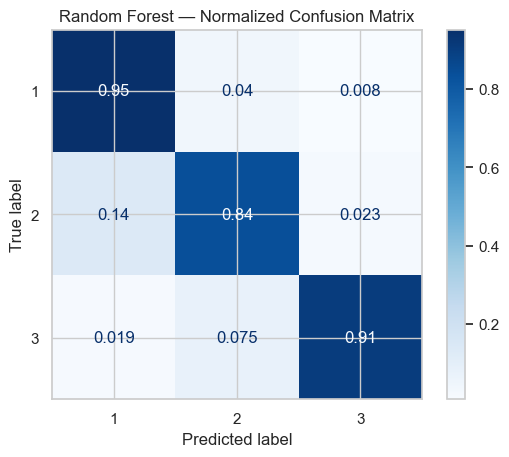

In [11]:
rf_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])
_ = evaluate_model('Random Forest', rf_pipeline, X_train, y_train, X_test, y_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['FileName' 'Date' 'SegFile']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Gradient Boosting — Balanced Accuracy: 0.905, Macro F1: 0.903


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['FileName' 'Date' 'SegFile']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


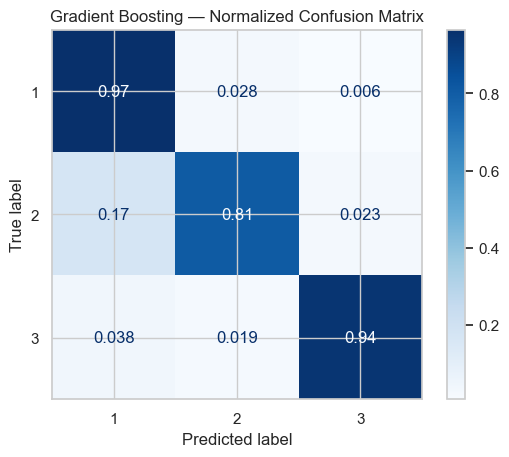

In [12]:
gb_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('gb', GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])
gb_fit_kwargs = {'gb__sample_weight': sample_weight_train}
_ = evaluate_model('Gradient Boosting', gb_pipeline, X_train, y_train, X_test, y_test, fit_kwargs=gb_fit_kwargs)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['FileName' 'Date' 'SegFile']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Neural Network (MLP) — Balanced Accuracy: 0.722, Macro F1: 0.769


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['FileName' 'Date' 'SegFile']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


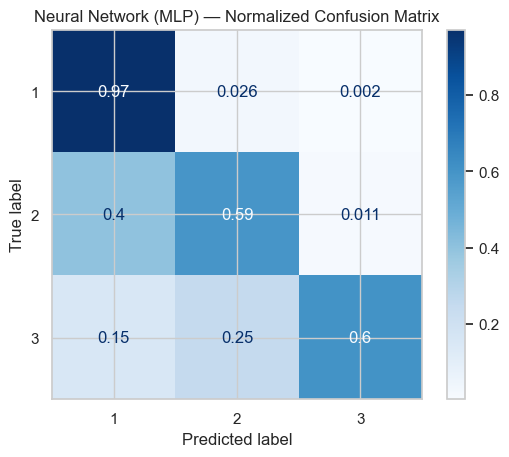

In [13]:
mlp_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        alpha=1e-3,
        learning_rate='adaptive',
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ))
])
_ = evaluate_model('Neural Network (MLP)', mlp_pipeline, X_train, y_train, X_test, y_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['FileName' 'Date' 'SegFile']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['FileName' 'Date' 'SegFile']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


k-Nearest Neighbors — Balanced Accuracy: 0.710, Macro F1: 0.760


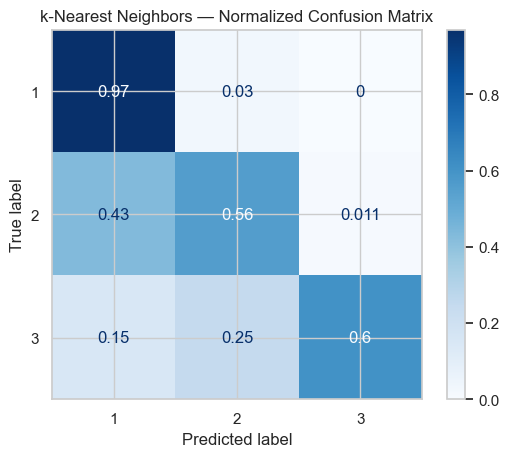

In [14]:
knn_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=15))
])
_ = evaluate_model('k-Nearest Neighbors', knn_pipeline, X_train, y_train, X_test, y_test)

In [15]:
# Aggregate model performance
results_df = pd.DataFrame(results).sort_values('Balanced Accuracy', ascending=False)
results_df.reset_index(drop=True)

,Model,Balanced Accuracy,F1 Macro
0,Gradient Boosting,0.91,0.90
1,Random Forest,0.90,0.89
2,Logistic Regression,0.84,0.78
3,Neural Network (MLP),0.72,0.77
4,k-Nearest Neighbors,0.71,0.76


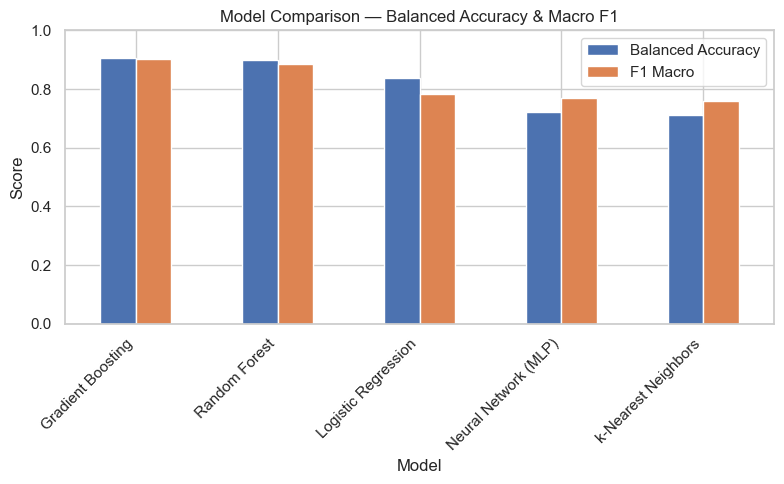

In [16]:
# Visual comparison
fig, ax = plt.subplots(figsize=(8, 5))
results_df.plot(x='Model', y=['Balanced Accuracy', 'F1 Macro'], kind='bar', ax=ax)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Model Comparison — Balanced Accuracy & Macro F1')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Conclusion and Model Used (Gradient Bossting)

In [ ]:

pd.DataFrame({
    'Split': ['Train', 'Test'],
    'Normal (1)': [np.mean(y_train == 1), np.mean(y_test == 1)],
    'Suspect (2)': [np.mean(y_train == 2), np.mean(y_test == 2)],
    'Pathologic (3)': [np.mean(y_train == 3), np.mean(y_test == 3)]
}).rename(columns=lambda c: c if c == 'Split' else f'{c} proportion')

gb_model.fit(X_train, y_train)

# Predict
y_pred = gb_model.predict(X_test) 

# Evaluate
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"Balanced Accuracy: {balanced_acc:.3f}")
print(f"F1 Macro Score: {f1_macro:.3f}")

ValueError: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values